# Global

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    root_path = "/content/drive/MyDrive/Try_Robotics2_project/"
except:
    root_path = "./"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
global opt_update, get_params, nn_forward_fn
global best_params, best_loss

# Arguments encoder
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

# Imports

In [ ]:
import argparse
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pickle as pkl

from copy import deepcopy as copy
from functools import partial # reduces arguments to function by making some subset implicit
from jax import jit
from jax import random
from jax.example_libraries import stax
from jax.example_libraries.stax import serial, Dense, Softplus, Tanh, elementwise, Relu
from jax.example_libraries import optimizers
from jax.experimental.ode import odeint
from jax.tree_util import tree_flatten
from tqdm import tqdm

# Utils

In [ ]:
def wrap_coords(state):
  # wrap generalized coordinates to [-pi, pi]
  return jnp.concatenate([(state[:2] + jnp.pi) % (2 * jnp.pi) - jnp.pi, state[2:]])

def rk4_step(f, x, t, h):
  # one step of Runge-Kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

def radial2cartesian(t1, t2, l1, l2):
  # Convert from radial to Cartesian coordinates.
  x1 = l1 * jnp.sin(t1)
  y1 = -l1 * jnp.cos(t1)
  x2 = x1 + l2 * jnp.sin(t2)
  y2 = y1 - l2 * jnp.cos(t2)
  return x1, y1, x2, y2

def write_to(data, path):
  with open(path, 'wb') as f:
    pkl.dump(data, f, protocol=pkl.HIGHEST_PROTOCOL)

def read_from(path):
  with open(path, 'rb') as f:
    data = pkl.load(f)
  return data

def plot_loss(train_losses, test_losses):
  fig, ax = plt.subplots(1, 1)

  ax.plot(train_losses, label='Train loss')
  ax.plot(test_losses, label='Test loss')
  ax.set_ylabel("Loss")
  ax.set_xlabel("Epochs")
  ax.legend()

  fig.tight_layout()

# Lagrangian Dynamics

In [ ]:
@jit
def ons(t):
  # return (kp*(np.pi/2-t1)-kd*w1)/(I+m1*(d1**2))
  return np.pi/2
  # print("Large")
  # jax.debug.print("maj_t: {}", time)

@jit
def dos(t):
  return np.pi/4
  # return (kp*(np.pi/4-t1)-kd*w1)/(I+m1*(d1**2))
  # print("Small")
  # jax.debug.print("min_t: {}", time)

@jit
def tres(t):
  return -np.pi/4
  # return (kp*(np.pi/4-t1)-kd*w1)/(I+m1*(d1**2))
  # print("Small")
  # jax.debug.print("min_t: {}", time)

@jit
def noooo(t):
  return 0.0
  # return (kp*(np.pi/4-t1)-kd*w1)/(I+m1*(d1**2))
  # print("Small")
  # jax.debug.print("min_t: {}", time)

# unconstrained equation of motion
def unconstrained_eom(model, state, t=None):
  q, q_t = jnp.split(state, 2)
  return jnp.concatenate([q_t, model(q, q_t).reshape([1])])

# lagrangian equation of motion
def lagrangian_eom(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  #Note: the following line assumes q is an angle. Delete it for problems other than double pendulum.
  q = q % (2*jnp.pi)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  dt = 1e-1
  return dt*jnp.concatenate([q_t, q_tt])

def raw_lagrangian_eom(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  q = q % (2*jnp.pi)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

def cntrl_raw_lagrangian_eom(lagrangian, state, t):
  kp = 2
  kd = 0.5
  m = 0.25
  d = 0.15
  I= 0.01125
  g= 9.81

  q, q_t = jnp.split(state, 2)
  # q = q % (2*jnp.pi)

  val_1 = lax.cond(t<jnp.array(2.0), ons,noooo, t)
  val_2 = lax.cond(jnp.logical_and(t>=jnp.array(2.0),t<jnp.array(5.0)), dos,noooo, t)
  val_3 = lax.cond(t>=jnp.array(5.0), tres,noooo, t)


  val = val_1+val_2+val_3

  jax.debug.print("t: {} || val: {}",t,val)

  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t)) + (kp*(val-q) - kd*q_t + m*g*d*jnp.sin(q))/(I+m*(d**2))
  return jnp.concatenate([q_t, q_tt])

def lagrangian_eom_rk4(lagrangian, state, n_updates, Dt=1e-1, t=None):
    @jax.jit
    def cur_fnc(state):
        q, q_t = jnp.split(state, 2)
        q = q % (2*jnp.pi)
        q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
                 @ (jax.grad(lagrangian, 0)(q, q_t)
                 - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
        return jnp.concatenate([q_t, q_tt])

    @jax.jit
    def get_update(update):
        dt = Dt/n_updates
        cstate = state + update
        k1 = dt*cur_fnc(cstate)
        k2 = dt*cur_fnc(cstate + k1/2)
        k3 = dt*cur_fnc(cstate + k2/2)
        k4 = dt*cur_fnc(cstate + k3)
        return update + 1.0/6.0 * (k1 + 2*k2 + 2*k3 + k4)

    update = 0
    for _ in range(n_updates):
        update = get_update(update)
    return update


def solve_dynamics(dynamics_fn, initial_state, is_lagrangian=True, **kwargs):
  eom = lagrangian_eom if is_lagrangian else unconstrained_eom

  # We currently run odeint on CPUs only, because its cost is dominated by
  # control flow, which is slow on GPUs.
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(eom, dynamics_fn), initial_state, **kwargs)
  return f(initial_state)


def custom_init(init_params, seed=0):
    """Do an optimized LNN initialization for a simple uniform-width MLP"""
    import numpy as np
    new_params = []
    rng = jax.random.PRNGKey(seed)
    i = 0
    number_layers = len([0 for l1 in init_params if len(l1) != 0])
    for l1 in init_params:
        if (len(l1)) == 0: new_params.append(()); continue
        new_l1 = []
        for l2 in l1:
            if len(l2.shape) == 1:
                #Zero init biases
                new_l1.append(jnp.zeros_like(l2))
            else:
                n = max(l2.shape)
                first = int(i == 0)
                last = int(i == number_layers - 1)
                mid = int((i != 0) * (i != number_layers - 1))
                mid *= i

                std = 1.0/np.sqrt(n)
                std *= 2.2*first + 0.58*mid + n*last

                if std == 0:
                    raise NotImplementedError("Wrong dimensions for MLP")

                new_l1.append(jax.random.normal(rng, l2.shape)*std)
                rng += 1
                i += 1

        new_params.append(new_l1)

    return new_params

# Physics

In [ ]:
import jax.lax as lax
@jit
def test_kinetic_energy(state, m1=0.25, l1=0.3, g=9.81, I=0.01125, d1=0.15):
    q, q_dot = jnp.split(state, 2)
    t1, w1 = q, q_dot
    T = 0.5 * (I + m1*(d1**2))*(w1**2)
    return T

@jit
def test_potential_energy(state, m1=0.25, l1=0.3, g=9.81, I=0.01125, d1=0.15):
    q, q_dot = jnp.split(state, 2)
    t1, w1 = q, q_dot
    V = -m1*g*d1*jnp.cos(t1)
    return V

@jit
def kinetic_energy(q, q_dot, m1=0.25, l1=0.3, g=9.81, I=0.01125, d1=0.15):
  t1, w1 = q, q_dot
  T = 0.5 * (I + m1*(d1**2))*(w1**2)
  return T

@jit
def potential_energy(q, q_dot, m1=0.25, l1=0.3, g=9.81, I=0.01125, d1=0.15):
  t1, w1 = q, q_dot
  V = -m1*g*d1*jnp.cos(t1)
  return V

# Double pendulum lagrangian
@jit
def lagrangian_fn(q, q_dot, m1=0.25, l1=0.3, g=9.81, I=0.01125, d1=0.15):
  T = kinetic_energy(q, q_dot)
  V = potential_energy(q, q_dot)
  return jnp.sum(T - V)

@jit
def analytical_fn(state, t=0, m1=0.25, l1=0.3, g=9.81, I=0.01125, d1=0.15):
  t1, w1 = state
  a1 = 0
  f1 = -m1*g*d1*jnp.sin(t1)/(I+m1*(d1**2))
  g1 = f1
  return jnp.stack([w1,g1])

@jit
def first_cond(t):
  return np.pi/2

@jit
def second_cond(t):
  return np.pi/4

@jit
def third_cond(t):
  return -np.pi/4

@jit
def default_out(t):
  return 0.0

@jit
def cntrl_fn(state, t, m1=0.25, l1=0.3, g=9.81, I=0.01125, d1=0.15, kp=2, kd=0.5):
  t1, w1 = state

  val_1 = lax.cond(t<jnp.array(2.0), first_cond,default_out, t)
  val_2 = lax.cond(jnp.logical_and(t>=jnp.array(2.0),t<jnp.array(5.0)), second_cond,default_out, t)
  val_3 = lax.cond(t>=jnp.array(5.0), third_cond,default_out, t)


  val = val_1+val_2+val_3

  jax.debug.print("t: {} || qd: {}", t,val)

  a1 = 0
  f1 = (kp*(val-t1)-kd*w1)/(I+m1*(d1**2))
  g1 = f1
  return jnp.stack([w1,g1])

# Data

In [ ]:
@partial(jax.jit, backend='cpu')
def get_trajectory(y0, times, use_lagrangian=False, **kwargs):
  if use_lagrangian:
    y = solve_dynamics(lagrangian_fn, y0, t=times, is_lagrangian=True, rtol=1e-10, atol=1e-10, **kwargs)
  else:
    y = odeint(analytical_fn, y0, t=times, rtol=1e-10, atol=1e-10, **kwargs)
  return y

@partial(jax.jit, backend='cpu')
def get_trajectory_lagrangian(y0, times, **kwargs):
  return solve_dynamics(lagrangian_fn, y0, t=times, is_lagrangian=True, rtol=1e-10, atol=1e-10, **kwargs)

@partial(jax.jit, backend='cpu')
def get_trajectory_analytic(y0, times, **kwargs):
    return odeint(analytical_fn, y0, t=times, rtol=1e-10, atol=1e-10, **kwargs)

@partial(jax.jit, backend='cpu')
def get_trajectory_cntrl(y0, times, **kwargs):
    return odeint(cntrl_fn, y0, t=times, rtol=1e-3, atol=1e-3, **kwargs)

def test_dataset(rng, samples=1, t_span=[0, 10], fps=100, test_split=0.5, lookahead=1,
                    unlimited_steps=False, init_pos=2.0*np.pi, init_vel=0.1, **kwargs):
    data = {'meta': locals()}
    vfnc = jax.jit(jax.vmap(analytical_fn))
    vget = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic, mxstep=100), (0, None), 0))
    vget_unlimited = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic), (0, None), 0))
    # randomly sample inputs

    frames = int(fps*(t_span[1]-t_span[0]))
    times = jnp.linspace(t_span[0], t_span[1], frames)
    y0 = jnp.concatenate([init_pos,init_vel], axis=1)

    if unlimited_steps:
      y = vget(y0, times)
    else:
      y = vget_unlimited(y0, times)

    print("Initial position: ", y0[0][0])
    print("Initial velocity: ", y0[0][1])

    data['x'] = y[:, :-lookahead]
    data['dx'] = y[:, lookahead:] - data['x']
    data['x'] = jnp.concatenate(data['x'])
    data['dx'] = jnp.concatenate(data['dx'])
    data['t'] = jnp.tile(times[:-lookahead], (samples,))

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx', 't']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

def noise_test_dataset(rng, samples=1, t_span=[0, 10], fps=100, test_split=0.5, lookahead=1,
                    unlimited_steps=False, init_pos=2.0*np.pi, init_vel=0.1, **kwargs):
    data = {'meta': locals()}
    vfnc = jax.jit(jax.vmap(analytical_fn))
    vget = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic, mxstep=100), (0, None), 0))
    vget_unlimited = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic), (0, None), 0))
    # randomly sample inputs

    frames = int(fps*(t_span[1]-t_span[0]))
    times = jnp.linspace(t_span[0], t_span[1], frames)
    y0 = jnp.concatenate([
        jax.random.uniform(rng, (samples, 1))*init_pos,
        jax.random.uniform(rng+1, (samples, 1))*init_vel
    ], axis=1)

    if unlimited_steps:
      y = vget(y0, times)
    else:
      y = vget_unlimited(y0, times)

    data['x'] = y[:, :-lookahead]
    data['x'] += jax.random.uniform(rng, data['x'].shape)*np.pi/2
    data['dx'] = y[:, lookahead:] - data['x']
    data['x'] = jnp.concatenate(data['x'])
    data['dx'] = jnp.concatenate(data['dx'])
    data['t'] = jnp.tile(times[:-lookahead], (samples,))

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx', 't']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

def cntrl_test_dataset(rng, samples=1, t_span=[0, 10], fps=100, test_split=0.5, lookahead=1,
                    unlimited_steps=False, init_pos=2.0*np.pi, init_vel=0.1, **kwargs):
    data = {'meta': locals()}
    vfnc = jax.jit(jax.vmap(analytical_fn))
    vget = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic, mxstep=100), (0, None), 0))
    vget_unlimited = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_cntrl), (0, None), 0))
    # randomly sample inputs

    frames = int(fps*(t_span[1]-t_span[0]))
    times = jnp.linspace(t_span[0], t_span[1], frames)
    init_pos_arr = jnp.array([init_pos]).reshape([1,1])
    init_vel_arr = jnp.array([init_vel]).reshape([1,1])

    y0 = jnp.concatenate([
        init_pos_arr,
        init_vel_arr
    ], axis=1)

    # print(y0)

    if unlimited_steps:
      y = vget(y0, times)
    else:
      y = vget_unlimited(y0, times)

    print("Initial position: ", y0[0][0])
    print("Initial velocity: ", y0[0][1])

    data['x'] = y[:, :-lookahead]
    data['dx'] = y[:, lookahead:] - data['x']
    data['x'] = jnp.concatenate(data['x'])
    data['dx'] = jnp.concatenate(data['dx'])
    data['t'] = jnp.tile(times[:-lookahead], (samples,))

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx', 't']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

def energy_test_dataset(rng, samples=1, t_span=[0, 10], fps=100, test_split=0.5, lookahead=1,
                    unlimited_steps=False, init_pos=2.0*np.pi, init_vel=0.1, **kwargs):
    data = {'meta': locals()}
    vfnc = jax.jit(jax.vmap(analytical_fn))
    vget = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic, mxstep=100), (0, None), 0))
    venergy = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_lagrangian), (0, None), 0))
    # randomly sample inputs

    frames = int(fps*(t_span[1]-t_span[0]))
    times = jnp.linspace(t_span[0], t_span[1], frames)
    y0 = jnp.concatenate([
        jax.random.uniform(rng, (samples, 1))*init_pos,
        jax.random.uniform(rng+1, (samples, 1))*init_vel
    ], axis=1)

    if unlimited_steps:
      y = vget(y0, times)
    else:
      y = venergy(y0, times)

    data['x'] = y[:, :-lookahead]
    data['x'] += jax.random.uniform(rng, data['x'].shape)*np.pi/2
    data['dx'] = y[:, lookahead:] - data['x']
    data['x'] = jnp.concatenate(data['x'])
    data['dx'] = jnp.concatenate(data['dx'])
    data['t'] = jnp.tile(times[:-lookahead], (samples,))

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx', 't']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

# Models

In [ ]:
sigmoid = jit(lambda x: 1/(1+jnp.exp(-x)))
swish = jit(lambda x: x/(1+jnp.exp(-x)))
relu3 = jit(lambda x: jnp.clip(x, 0.0, float('inf'))**3)
Swish = elementwise(swish)
Relu3 = elementwise(relu3)

def extended_mlp(args):
    act = {
        'softplus': [Softplus, Softplus],
        'swish': [Swish, Swish],
        'tanh': [Tanh, Tanh],
        'tanh_relu': [Tanh, Relu],
        'soft_relu': [Softplus, Relu],
        'relu_relu': [Relu, Relu],
        'relu_relu3': [Relu, Relu3],
        'relu3_relu': [Relu3, Relu],
        'relu_tanh': [Relu, Tanh],
    }[args.act]
    hidden = args.hidden_dim
    output_dim = args.output_dim
    nlayers = args.layers

    layers = []
    layers.extend([
        Dense(hidden),
        act[0]
    ])
    for _ in range(nlayers - 1):
        layers.extend([
            Dense(hidden),
            act[1]
        ])

    layers.extend([Dense(output_dim)])

    return stax.serial(*layers)

# Loss

In [ ]:
# replace the lagrangian with a parameteric model
def learned_dynamics(params):
  @jit
  def dynamics(q, q_t):
#     assert q.shape == (2,)
    state = wrap_coords(jnp.concatenate([q, q_t]))
    return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
  return dynamics

def make_loss(args):
    if args.loss == 'lnn':
        @jax.jit
        def gln_loss(params, batch, l2reg):
            state, targets = batch#_rk4
            leaves, _ = tree_flatten(params)
            l2_norm = sum(jnp.vdot(param, param) for param in leaves)
            preds = jax.vmap(partial(lagrangian_eom_rk4, learned_dynamics(params), Dt=args.dt, n_updates=args.n_updates))(state)
            return jnp.sum(jnp.abs(preds - targets)) + l2reg*l2_norm/args.batch_size

    elif args.loss == 'baseline_nn':
        @jax.jit
        def gln_loss(params, batch, l2reg):
          state, targets = batch
          preds = jax.vmap(partial(unconstrained_eom, learned_dynamics(params)))(state)
          return jnp.sqrt(jnp.mean((preds - targets) ** 2))

    else:
        print("---------------------- SELECT A CORRECT LOSS ----------------------")
        exit(0)

    return gln_loss

# Test

In [ ]:
def get_cntrl_action(pos,vel,kp=5,kd=2,qd=np.pi/2,m=0.25,g=9.81,d=0.15):
  cntrl_action = []
  gravity = []
  qd_s = jnp.array([])
  cntrl_action = kp*(jnp.array([qd for _ in range(len(pos))])-pos) - kd*vel + (m*g*d*jnp.sin(pos))
  gravity = m*g*d*jnp.sin(pos)

  return cntrl_action, gravity

In [ ]:
max_t = 10
test_set = cntrl_test_dataset(jax.random.PRNGKey(2),
                        t_span=[0, max_t],
                        fps=100, test_split=1.0,
                        unlimited_steps=False,
                        init_pos=np.pi/4,
                        init_vel=0)

In [ ]:
def multi_get_cntrl_action(pos,vel,time,qds,kp=5,kd=2,m=0.25,g=9.81,d=0.15):
  cntrl_action = []
  gravity = []

  for t in range(len(time)):
    if(time[t] < 2.0):
      cntrl_action.append(kp*(qds[0]-pos[t]) - kd*vel[t] + (m*g*d*jnp.sin(pos[t])))
    if(time[t]>=2.0 and time[t]<5.0):
      cntrl_action.append(kp*(qds[1]-pos[t]) - kd*vel[t] + (m*g*d*jnp.sin(pos[t])))
    if(time[t]>=5.0):
      cntrl_action.append(kp*(qds[2]-pos[t]) - kd*vel[t] + (m*g*d*jnp.sin(pos[t])))
    gravity.append(m*g*d*jnp.sin(pos[t]))

  return cntrl_action, gravity

999
0.367875
0.25923395
-0.2601217


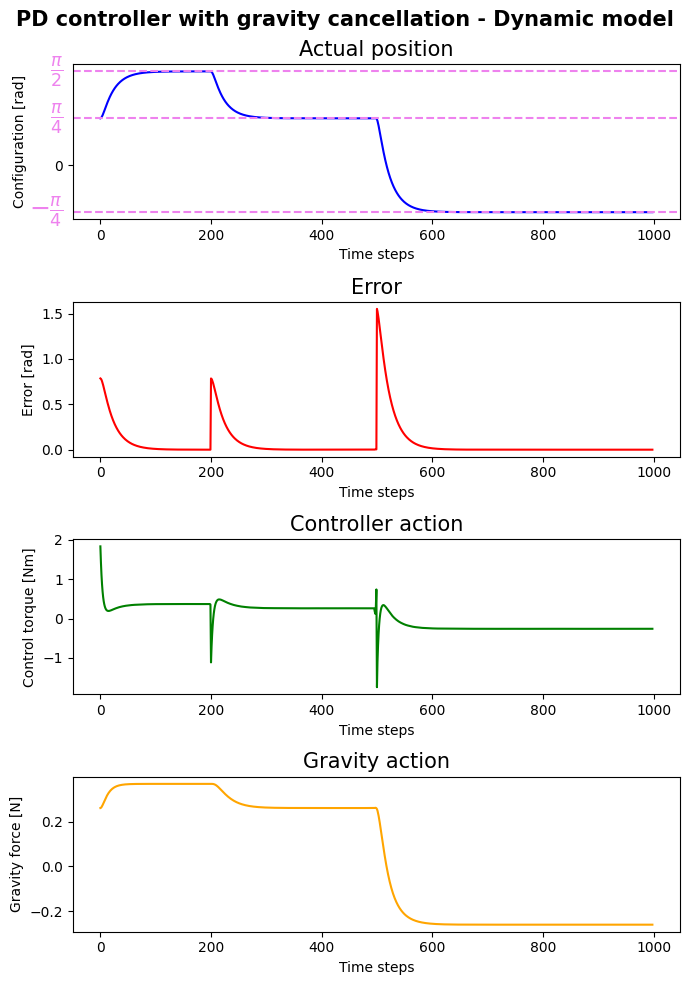

In [ ]:
qds = [np.pi/2, np.pi/4, -np.pi/4]
real_cntrl_action, real_gravity = multi_get_cntrl_action(
    pos=test_set['x'][:,0],
    vel=test_set['x'][:,1],
    time=test_set['t'],
    qds=qds,kp=2,kd=0.5,m=0.25,g=9.81,d=0.15)

print(real_gravity[199])
print(real_gravity[499])
print(real_gravity[-1])

real_error = []

for t in range(len(test_set['t'])):
  if(test_set['t'][t] < 2.0):
    real_error.append(abs(qds[0]-test_set['x'][t,0]))
  if(test_set['t'][t]>=2.0 and test_set['t'][t]<5.0):
    real_error.append(abs(qds[1]-test_set['x'][t,0]))
  if(test_set['t'][t]>=5.0):
    real_error.append(abs(qds[2]-test_set['x'][t,0]))

fig, ax = plt.subplots(4, 1, figsize=(7,10))

trans = transforms.blended_transform_factory(ax[0].get_yticklabels()[0].get_transform(), ax[0].transData)
fig.suptitle("PD controller with gravity cancellation - Dynamic model",fontsize=15,fontweight="bold")

ax[0].set_title("Actual position",fontsize=15)
ax[0].plot(test_set['x'][:,0],color='blue')
ax[0].axhline(y = qds[0], color = 'violet', linestyle = '--')
ax[0].text(0,qds[0], r"$\frac{\pi}{2}$", color="violet", transform=trans, ha="right", va="center", fontsize=18)
ax[0].axhline(y = qds[1], color = 'violet', linestyle = '--')
ax[0].text(0,qds[1], r"$\frac{\pi}{4}$", color="violet", transform=trans, ha="right", va="center", fontsize=18)
ax[0].axhline(y = qds[2], color = 'violet', linestyle = '--')
ax[0].text(0,qds[2], r"$-\frac{\pi}{4}$", color="violet", transform=trans, ha="right", va="center", fontsize=18)
ax[0].set_yticks([0])
ax[0].set_ylabel('Configuration [rad]',rotation=90,fontsize=10,labelpad=20)
ax[0].set_xlabel('Time steps',fontsize=10)

ax[1].set_title("Error",fontsize=15)
ax[1].plot(real_error, color='red')
ax[1].set_ylabel('Error [rad]',rotation=90,fontsize=10)
ax[1].set_xlabel('Time steps',fontsize=10)

ax[2].set_title("Controller action",fontsize=15)
ax[2].plot(real_cntrl_action, color='green')
ax[2].set_ylabel('Control torque [Nm]',rotation=90,fontsize=10)
ax[2].set_xlabel('Time steps',fontsize=10)

ax[3].set_title("Gravity action",fontsize=15)
ax[3].plot(real_gravity, color='orange')
ax[3].set_ylabel('Gravity force [N]',rotation=90,fontsize=10)
ax[3].set_xlabel('Time steps',fontsize=10)

fig.tight_layout()

In [ ]:
def lnn_get_cntrl_action(pos,vel,kp=5,kd=2,qd=np.pi/2,m=0.25,g=9.81,d=0.15):
  cntrl_action = []
  gravity = []
  for i in range(len(pos)):
    a = kp*(qd-pos[i]) - kd*vel[i] + (m*g*d*np.sin(pos[i]))
    b = m*g*d*np.sin(pos[i])
    cntrl_action.append(a)
    gravity.append(b)
  return cntrl_action, gravity

In [ ]:
def multi_lnn_get_cntrl_action(pos,vel,time,qds,kp=5,kd=2,qd=np.pi/2,m=0.25,g=9.81,d=0.15):
  cntrl_action = []
  gravity = []

  for t in range(len(time)):
    if(time[t] < 2.0):
      cntrl_action.append(kp*(qds[0]-pos[t]) - kd*vel[t] + (m*g*d*jnp.sin(pos[t])))
    if(time[t]>=2.0 and time[t]<5.0):
      cntrl_action.append(kp*(qds[1]-pos[t]) - kd*vel[t] + (m*g*d*jnp.sin(pos[t])))
    if(time[t]>=5.0):
      cntrl_action.append(kp*(qds[2]-pos[t]) - kd*vel[t] + (m*g*d*jnp.sin(pos[t])))
    gravity.append(m*g*d*jnp.sin(pos[t]))

  return cntrl_action, gravity

In [ ]:
str_loss = "lnn"
loaded_model = read_from(root_path + "Rigid/LNN/" + str_loss + "_rigid_params.pkl") #colab
args = loaded_model['args']
best_params = loaded_model['params']
opt_init, opt_update, get_params = optimizers.adam(args.lr)
opt_state = opt_init(best_params)
_, nn_forward_fn = extended_mlp(args)
model = (nn_forward_fn, best_params)
p = get_params(opt_state)

t_span=[0, 10]
fps = 100
init_pos = np.pi/4
init_vel = 0

frames = int(fps*(t_span[1]-t_span[0]))
times = jnp.linspace(t_span[0], t_span[1], frames)
init_pos_arr = jnp.array([init_pos]).reshape([1,1])
init_vel_arr = jnp.array([init_vel]).reshape([1,1])

y0 = jnp.concatenate([
    init_pos_arr,
    init_vel_arr
], axis=1)

model_predictions = jax.device_get(odeint(partial(cntrl_raw_lagrangian_eom, learned_dynamics(p)),y0[0],times,rtol=1e-6, atol=1e-6))

0.36787483
0.25872922
-0.2575136


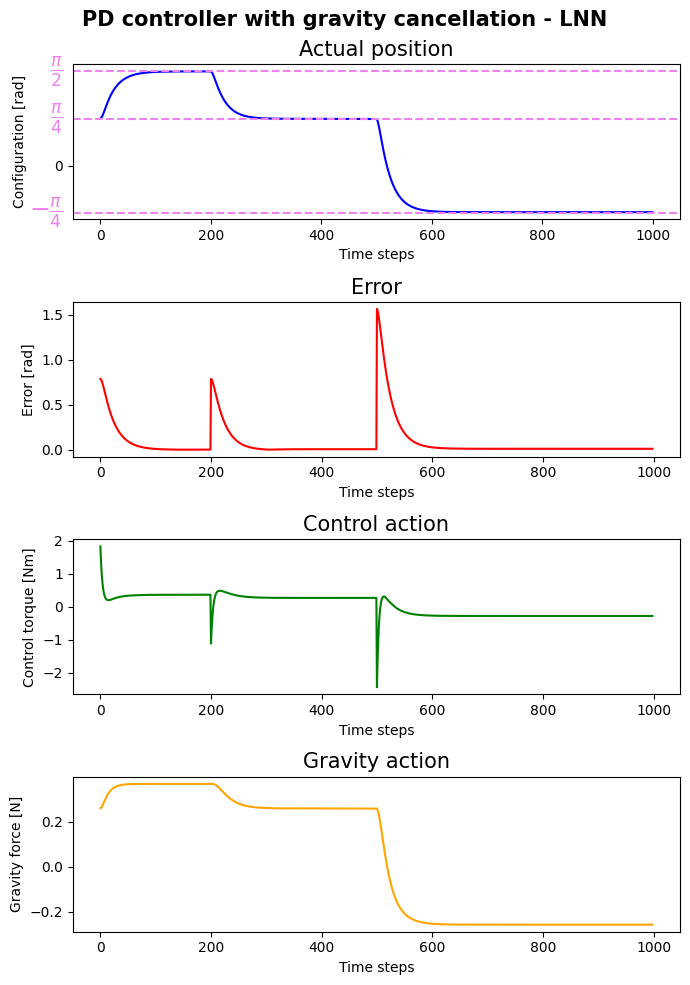

In [ ]:
lnn_cntrl, lnn_gravity = multi_lnn_get_cntrl_action(model_predictions[:,0],model_predictions[:,1],test_set['t'],qds,kp=2,kd=0.5,qd=np.pi/2,m=0.25,g=9.81,d=0.15)

print(lnn_gravity[199])
print(lnn_gravity[499])
print(lnn_gravity[-1])

fig, ax = plt.subplots(4, 1, figsize=(7,10))
trans = transforms.blended_transform_factory(ax[0].get_yticklabels()[0].get_transform(), ax[0].transData)

lnn_error = []
for t in range(len(test_set['t'])):
  if(test_set['t'][t] < 2.0):
    lnn_error.append(abs(qds[0]-model_predictions[t,0]))
  if(test_set['t'][t]>=2.0 and test_set['t'][t]<5.0):
    lnn_error.append(abs(qds[1]-model_predictions[t,0]))
  if(test_set['t'][t]>=5.0):
    lnn_error.append(abs(qds[2]-model_predictions[t,0]))

fig.suptitle("PD controller with gravity cancellation - LNN",fontsize=15,fontweight="bold")

ax[0].set_title("Actual position",fontsize=15)
ax[0].plot(model_predictions[:,0],color='blue')
ax[0].axhline(y = qds[0], color = 'violet', linestyle = '--')
ax[0].text(0,qds[0], r"$\frac{\pi}{2}$", color="violet", transform=trans, ha="right", va="center", fontsize=18)
ax[0].axhline(y = qds[1], color = 'violet', linestyle = '--')
ax[0].text(0,qds[1], r"$\frac{\pi}{4}$", color="violet", transform=trans, ha="right", va="center", fontsize=18)
ax[0].axhline(y = qds[2], color = 'violet', linestyle = '--')
ax[0].text(0,qds[2], r"$-\frac{\pi}{4}$", color="violet", transform=trans, ha="right", va="center", fontsize=18)
ax[0].set_yticks([0])
ax[0].set_ylabel('Configuration [rad]',rotation=90,fontsize=10,labelpad=20)
ax[0].set_xlabel('Time steps',fontsize=10)

ax[1].set_title("Error",fontsize=15)
ax[1].plot(lnn_error,color='red')
ax[1].set_ylabel('Error [rad]',rotation=90,fontsize=10)
ax[1].set_xlabel('Time steps',fontsize=10)

ax[2].set_title("Control action",fontsize=15)
ax[2].plot(lnn_cntrl,color='green')
ax[2].set_ylabel('Control torque [Nm]',rotation=90,fontsize=10)
ax[2].set_xlabel('Time steps',fontsize=10)

ax[3].set_title("Gravity action",fontsize=15)
ax[3].plot(lnn_gravity,color='orange')
ax[3].set_ylabel('Gravity force [N]',rotation=90,fontsize=10)
ax[3].set_xlabel('Time steps',fontsize=10)

fig.tight_layout()